# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_scv(res1, res2):
    try:
        df = pd.read_csv(res1)
    except:
        df = pd.read_csv(res2)
    return df

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def first_look(df):
    print(f"Количество дубликатов в {namestr(df, globals())[0]} равно {df['id'].duplicated().sum()}")
    print(f"При этом количество полных дубликатов {df.duplicated().sum()}")
    print("_ "*40)
    print(df.info())
    print("_ "*40)
    print(df.describe())
    print("_ "*40)
    print("Корреляция признаков")
    print(df.corr())
    df.hist(figsize=(10,5), bins=100);
    
    

In [3]:
df_0 = read_scv('geo_data_0.csv', '/datasets/geo_data_0.csv')
df_1 = read_scv('geo_data_1.csv', '/datasets/geo_data_1.csv')
df_2 = read_scv('geo_data_2.csv', '/datasets/geo_data_2.csv')

df_all = [df_0, df_1, df_2]

df_2.head(2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


Вообще, нам первый столбец не нужен, так же предполагаем, что id должны быть уникальными, но по факту видим, что в них есть дубликаты в названиях. В одном датасете 10 штук, в двух других по 4. Причем дубликаты неполные, то есть признаки у них разные. Скорее всего это какая то техническая ошибка. Делать с этим ничего не будем, так как для модели этот столбец использовать не будем.  
Так же посмотрим в целом на датасеты и меры признаков.

Количество дубликатов в df_0 равно 10
При этом количество полных дубликатов 0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       

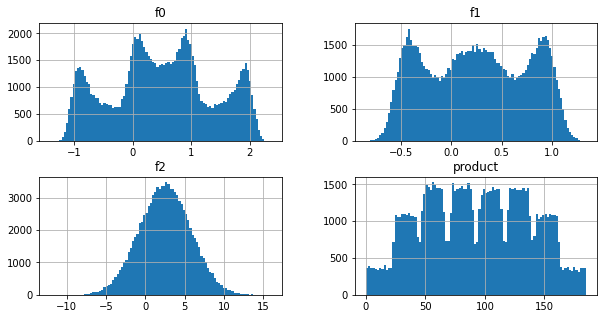

In [4]:
first_look(df_0)

Количество дубликатов в df_1 равно 4
При этом количество полных дубликатов 0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0

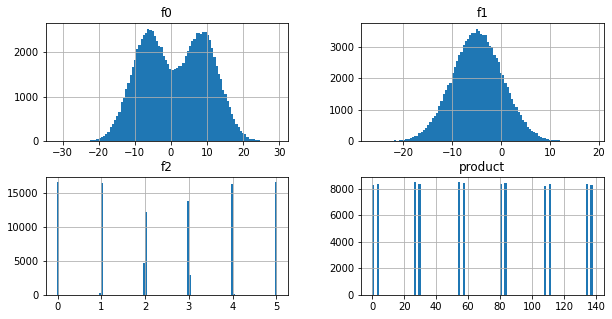

In [5]:
first_look(df_1)

Количество дубликатов в df_2 равно 4
При этом количество полных дубликатов 0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0

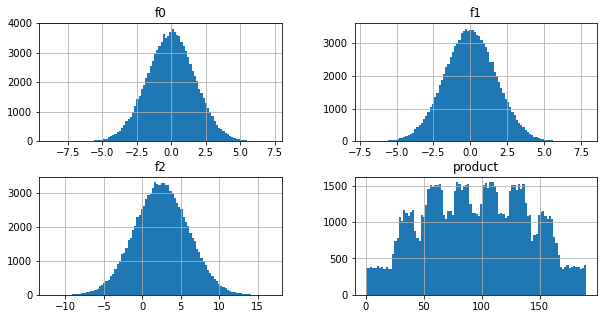

In [6]:
first_look(df_2)

Какие интересные есть многомодальные распределения значений у признаков

**Предварительные выводы:**  
- Загрузили данные, проверили на наличие дубликатов. Есть дубликаты в id, но они нам не помешают, так как для построения модели данный столбец использовать не будем. При этом полных дубликатов нет.
- Так же нет пропусков в данных и аномальных значений (ярковыраженных выбросов).
- Распределения признаков и целевой переменной интересные, есть признаки с нормальным распределением, есть ярковыраженные многомодальные распределения.
- Посмотрели корреляцию. У всех датасетов она разная. Во втором датасете между признаком f2 и целевой переменной корреляция практически единица.

## Обучение и проверка модели

По условиям задания будем использовать линейную регрессию. Разбивка train - valid будет в соотношении 75:25.
Признаки будем нормализовать StandartScaler.  
Так как у нас по условии задачи только LInearRegression поиск по сетке использовать не будем. Попробуем освоить на базовом уровне пайплайн, в котором одним из шагов будем добавлять полинаомиальные признаки (2-3-4 степень признаков)

In [7]:
y_pred_all = []
y_valid_all = []

for df in df_all:
    #разобьем выборку по условиям задания
    X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['id','product'], axis=1),
                                                          df['product'],
                                                          random_state=666,
                                                          test_size=0.25)
    # соберем простенький пайплайн. Предобработка StandartScaler, генерим полиномальные фичи PolynomialFeatures, модель - линейная регрессия
    pipe = Pipeline(steps=[
                      ('scaler', StandardScaler()),
                      ('poly', PolynomialFeatures(degree=4, include_bias=False)),
                      ('regressor', LinearRegression())
                      ])

    # обучим и предскажем
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)

    # Не знаю, может это костыль, переведем предсказания в сериз и присвоим индексам те же значения, что и в валидационной выборке
    y_pred = pd.Series(y_pred)
    y_pred.index = y_valid.index

    # запишем в списки предсказания и валид
    y_pred_all.append(y_pred)
    y_valid_all.append(y_valid)

    # напечатаем метрики модели
    print(f"Для региона {namestr(df, globals())[0]}")
    print('Train : Valid = ', 
          round(100*X_train.shape[0]/df.shape[0],0), ":",
          round(100*X_valid.shape[0]/df.shape[0],0))
    print(f"model score (R2): {pipe.score(X_valid, y_valid):.3f}")
    print(f"RMSE: {mse(y_valid, y_pred)**0.5:.3f}")    
    # выведем средний уровень объема скважины
    print(f"Средний объем одной скважины в предсказанной выборке составил: {y_pred.mean():.3f} тыс.баррелей")
    print("_ "*40)

Для региона df_0
Train : Valid =  75.0 : 25.0
model score (R2): 0.289
RMSE: 37.389
Средний объем одной скважины в предсказанной выборке составил: 92.638 тыс.баррелей
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Для региона df_1
Train : Valid =  75.0 : 25.0
model score (R2): 1.000
RMSE: 0.780
Средний объем одной скважины в предсказанной выборке составил: 69.121 тыс.баррелей
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Для региона df_2
Train : Valid =  75.0 : 25.0
model score (R2): 0.263
RMSE: 38.245
Средний объем одной скважины в предсказанной выборке составил: 95.060 тыс.баррелей
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


**Предварительные выводы:**  
- Сделали пайплайн с предобработкой скейлером (СтандартСкэйлер) и генерацию полиноминальных признаков.
- Посмотрели метрики (R2 и RMSE). Самое высокое качество во втором регионе (df_1), что объясняется полной корреляцией (почти 1) одного из признаков с целевой переменной. Добавление полиноминальных признаков увеличило качество модели (кроме второго региона).
- Сделали предикт объема нефти по валидационной выборке  
- Посмотрели среднюю добычу по предсказанным скважинам. Самая большая средняя добыча в третьем регионе (df_2) - 95 тыс.баррелей

## Подготовка к расчёту прибыли

Условия задачи поставлены не совсем русским языком. Очень сложно понять, что от меня требуется. Попробую перефразировать для собственного понимания:  
Бюджет на разработку скважин в регионе — 10 млрд рублей., а выбираем мы в конечном итоге 200 скважин из 500. Значит Бюджет на разработку 200 скважин 10 млрд.руб. Соответственно одной скважины 50 млн.руб.  
Для точки безубыточности объем одной скважины должен быть таким, чтобы выручка от проданной нефти была равна себестоимости (полной) одной скважины. 50 млн.руб. / 450 000

In [8]:
# Все ключевые значения для расчётов сохраним в отдельных переменных.

BUDGET = 10**10 #Бюджет на разработку скважин в регионе — 10 млрд рублей.
BUDGET_ONE_HOLE = BUDGET / 200 # Бюджет одной скважины по условиям задачи
INCOME_PER_1000_BARREL = 450_000 # При нынешних ценах один баррель сырья приносит 450 рублей дохода. Но у нас единица обема - это тыс.баррелей.
MIN_VOLUME = BUDGET_ONE_HOLE / INCOME_PER_1000_BARREL # точка безубыточности на одну скважину

print(f"Точка безубыточности одной скважины в среднем - {MIN_VOLUME:.6f} тыс. баррелей")

Точка безубыточности одной скважины в среднем - 111.111111 тыс. баррелей


**Предварительные выводы:**  
- Отметили, что средняя выработка скважин (по предсказаниям) ниже точки безубыточности. В лучшем случаем 95 тыс.баррелей против 111. Но это средняя - а мы ведь будем снимать сливки - брать только 200 лучших скважин ))

## Расчёт прибыли и рисков 

Тут тоже для себя переведем задание яндекса на русский язык.  
Нам нужно выбрать 200 лучших скважин. Но выбирать мы их будем по предсказаниям, а прибыль будем считать по факту. То есть это нам позволит как бы оценить, насколько хорошо отработает модель в реальной жизни. Образно мы предсказываем у скважин один объем, а выручку по жизни получим уже отличную от прогноза - фактическую. 

In [9]:
# напишем функцию для расчета прибыли по выбранным скважинам. Выбранных - 200 шт.
def revenue(target, predicted, count=200):
    predicted_sorted = predicted.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:count]
    profit = selected.sum() * INCOME_PER_1000_BARREL - count * BUDGET_ONE_HOLE
    return profit

In [10]:
for i in range(3):
    print("Прибыль для региона №{0}({1}) составляет {2:.3f} млрд. руб.".format(i+1, 
                                                                        namestr(df_all[i], globals())[0],
                                                                        revenue(y_valid_all[i], y_pred_all[i])/10**9))
    revenue(y_valid, y_pred)/10**9


Прибыль для региона №1(df_0) составляет 3.318 млрд. руб.
Прибыль для региона №2(df_1) составляет 2.415 млрд. руб.
Прибыль для региона №3(df_2) составляет 3.029 млрд. руб.


Таким образом, если мы в каждом регионе выберем лучшие 200 скважин из предсказанных, то прибыль составит соответственно:  
3.3 млрд руб. для первого региона.  
2.4 млрд руб. для второго региона.  
3.0 млрд руб. для третьего региона.  

Но по условиям задания мы теперь должны применить технику бутстрэп. Будем делать выборки по 500 скважин, 1000 раз в каждом регионе, и выбирать из них 200 лучших и смотреть прибыль.

In [11]:
state = np.random.RandomState(666)

for i in range(3):
    profit = []
    for _ in range(1000):
        y_pred = y_pred_all[i]
        y_valid = y_valid_all[i]

        y_pred_subsample = y_pred.sample(500, replace=True, random_state=state)
        y_valid_subsample = y_valid[y_pred_subsample.index] 
            
        profit.append(revenue(y_valid_subsample, y_pred_subsample))

    values = pd.Series(profit)
    
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    # Насколько понимаю, риск убытка - это доля отрицательных прибылей в списке прибылей
    negative_profit = 0
    for profit in values:
        if profit < 0:
            negative_profit += 1
    risk = (negative_profit / len(values))*100

    print(f"Для региона № {i+1} ({namestr(df_all[i], globals())[0]})")
    print(f"Средняя выручка: {mean/10**9:.3f} млрд. руб.")
    print(f"95%-й доверительный интервал лежит в диапазоне: ({lower/10**9:.3f}, {upper/10**9:.3f}) млрд. руб.")
    print(f"риск убытка составляет: {risk:.2f} %")
    print("_ "*20)

Для региона № 1 (df_0)
Средняя выручка: 0.522 млрд. руб.
95%-й доверительный интервал лежит в диапазоне: (0.012, 1.038) млрд. руб.
риск убытка составляет: 2.30 %
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Для региона № 2 (df_1)
Средняя выручка: 0.545 млрд. руб.
95%-й доверительный интервал лежит в диапазоне: (0.127, 0.984) млрд. руб.
риск убытка составляет: 0.80 %
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Для региона № 3 (df_2)
Средняя выручка: 0.661 млрд. руб.
95%-й доверительный интервал лежит в диапазоне: (0.160, 1.173) млрд. руб.
риск убытка составляет: 0.80 %
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


**Предварительные выводы:**  
- В этой части мы посмотрели, что в принципе в любом регионе можно выбрать 200 лучших скважин и оказаться в плюсе.
- Затем мы применили технику Бутстрэп и посмотрели, что самым оптимальным для выбора является третий регион, так как у него при выборе 200 скважин самая высокая средняя прибыль, риск убытка такой же как и во втором регионе и ниже чем в первом, а так же прибыль в 95% доверительном интервале выше чем у других регионов.

## Выводы  

* Данные довольно чистые, не требуют дополнительной обработки:  
    - Загрузили данные, проверили на наличие дубликатов. Есть дубликаты в id, но они нам не помешают, так как для построения модели данный столбец использовать не будем. При этом полных дубликатов нет.
    - Так же нет пропусков в данных и аномальных значений (ярковыраженных выбросов).
    - Распределения признаков и целевой переменной интересные, есть признаки с нормальным распределением, есть ярковыраженные многомодальные распределения.
    - Посмотрели корреляцию. У всех датасетов она разная. Во втором датасете между признаком f2 и целевой переменной корреляция практически единица.
* Обучили и проверили модель для каждого региона:
    - Сделали пайплайн с предобработкой скейлером (СтандартСкэйлер) и генерацию полиноминальных признаков.
    - Посмотрели метрики (R2 и RMSE). Самое высокое качество во втором регионе (df_1), что объясняется полной корреляцией (почти 1) одного из признаков с целевой переменной. Добавление полиноминальных признаков увеличило качество модели (кроме второго региона).
    - Сделали предикт объема нефти по валидационной выборке  
    - Посмотрели среднюю добычу по предсказанным скважинам. Самая большая средняя добыча в третьем регионе (df_2) - 95 тыс.баррелей
* Рассчитали, что средняя выработка скважин (по предсказаниям) ниже точки безубыточности. В лучшем случаем 95 тыс.баррелей против 111. Но это средняя - а мы ведь будем снимать сливки - брать только 200 лучших скважин  
* Расчитали возможные прибыли и риски по каждому региону
    - В этой части мы посмотрели, что в принципе в любом регионе можно выбрать 200 лучших скважин и оказаться в плюсе.
    - Затем мы применили технику Бутстрэп и посмотрели, что самым оптимальным для выбора является третий регион, так как у него при выборе 200 скважин самая высокая средняя прибыль, риск убытка такой же как и во втором регионе и ниже чем в первом, а так же прибыль в 95% доверительном интервале выше чем у других регионов.
    

